# Filter fragments for drug likeness

## Aim of this notebook

This notebook is filtering the fragments for drug likeness. 
* The first filter step checks whether the fragments fulfill the Rule of Three (Ro3) ([Drug Discovery Today, 2003, 8(19):876-877](https://www.sciencedirect.com/science/article/abs/pii/S1359644603028319?via%3Dihub)). 
* The second filter calculates the Quantitative Estimate of Druglikeness (QED) ([Nat Chem. 2012 Jan 24; 4(2): 90–98](https://www.nature.com/articles/nchem.1243)), reflecting the molecular properties of the fragments.

## Table of contents
1. Load fragment library
2. Apply pre-filters
3. Filter for Rule of Three (Ro3)
4. Filter for Quantitative Estimate of Druglikeness (QED)
5. Analyze accepted/rejected fragments

    5.1. Count number of fragments that are accepted by the filter(s)
    
    5.2. Histogram of QED values

## Imports and preprocessing

In [51]:
from pathlib import Path

import pandas as pd
from rdkit.Chem import PandasTools, QED, Draw

from IPython.core.display import HTML

from kinfraglib import filters, utils

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

### Define global Paths

In [54]:
# Path to data
HERE = Path().resolve()
PATH_DATA = HERE / "../../data"

## 1. Load fragment library

The fragment library is stored as a dictionary, with the individual subpockets as keys.

In [55]:
fragment_library_original = utils.read_fragment_library(PATH_DATA / "fragment_library")

In [56]:
fragment_library_original.keys()
# NBVAL_CHECK_OUTPUT

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])

In [57]:
pd.concat(fragment_library_original).reset_index(drop=True).shape
# NBVAL_CHECK_OUTPUT

(9505, 15)

## 2. Apply pre-filters
Pre-filters include 
- removing fragments in pool X
- removing duplicates
- removing fragments without dummy atoms (unfragmented ligands)
- removing fragments only connecting to pool X

In [58]:
fragment_library = filters.prefilters.pre_filters(fragment_library_original)

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]"
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 16 7 16 16 16 16 5 16 16 16 16 16 5 5 5 5 5 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]"
2,AP,CC1=C2/C(=N/c3ccccc3)N=CN=[N+]2C=C1,,,,AAK1,NAK,Other,8gmc,YFV,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 16 4 4 4 4...,[39*]c1cccc(/N=C2\N=CN=[N+]3C=CC(C[42*])=C23)c1,1,"[FP, FP]","[AP=FP, AP=FP]"
3,AP,Nc1ncnn2cccc12,,,,AAK1,NAK,Other,8gmd,ZRR,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP GA FP,14 14 14 14 14 14 14 16 14 14 14 14 5 5 na na,*Nc1ncnn2ccc([25*])c12,6,"[GA, FP]","[AP=GA, AP=FP]"
4,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,10,[SE],[AP=SE]

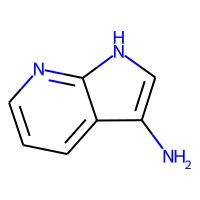
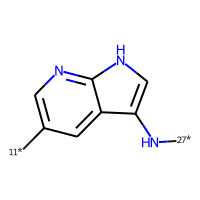
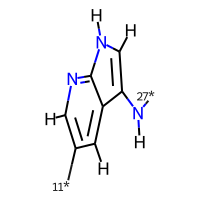
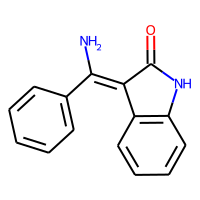
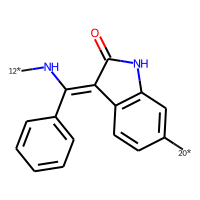
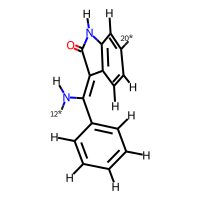
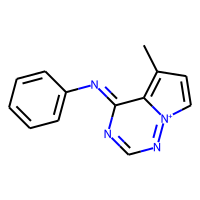
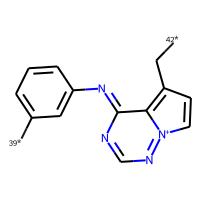
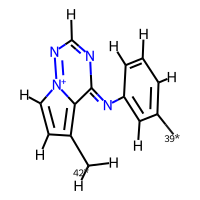
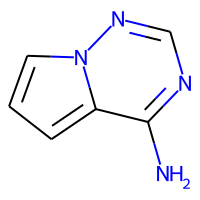
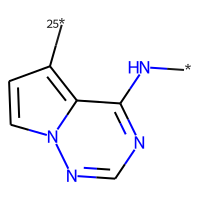
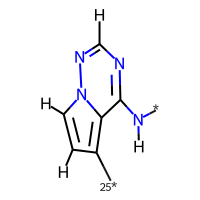
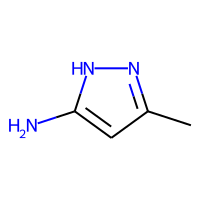
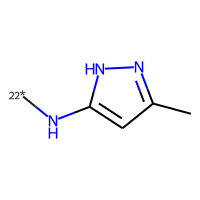
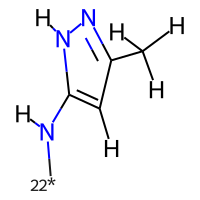

In [59]:
HTML(fragment_library["AP"].head().to_html(notebook=True))

Count number of fragments in the original fragment library and after pre-filtering the fragment library.

In [60]:
num_fragments = pd.concat(
    [
        filters.analysis.count_fragments(fragment_library_original, "original"),
        filters.analysis.count_fragments(fragment_library, "pre_filtered"),
    ],
    axis=1,
)
num_fragments = pd.concat([num_fragments, num_fragments.sum().rename("Total").to_frame().T])
num_fragments
# NBVAL_CHECK_OUTPUT

,original,pre_filtered
AP,3240,1201
FP,2385,1100
SE,1962,743
GA,1305,355
B1,126,47
B2,113,59
Total,9131,3505


Note: The number of fragments in pool X in the original fragment library is not displayed.

## 3. Filter for Rule of Three (Ro3)

The Rule of Three (Ro3) ([Drug Discovery Today, 2003, 8(19):876-877](https://www.sciencedirect.com/science/article/abs/pii/S1359644603028319?via%3Dihub)) is adapted from the Rule of Five (Ro5) ([
J Pharmacol Toxicol Methods, 2000, 44(1): 235-249](https://www.sciencedirect.com/science/article/abs/pii/S1056871900001076?via%3Dihub)) to check if small molecules make good lead compounds.
It is looking at the molecular properties, namely
- molecular weight (MW) <= 300
- logp <= 3
- number of hydrogen bond acceptor (HBA) <= 3
- number of hydrogen bond donor (HBD) <= 3
- number of rotatable bonds (NROT) <= 3
- polar surface area (PSA) <= 60

In [61]:
filters.drug_likeness.get_ro3_frags?

Signature:
filters.drug_likeness.get_ro3_frags(
    fragment_library,
    min_fulfilled=6,
    cutoff_crit='>=',
)
Docstring:
Check if the fragments fulfill the rule of three criteria
    - molecular weight <300
    - logp <=3
    - number of hydrogen bond acceptors <=3
    - number of hydrogen bond donors <=3
    - number of rotatable bonds <=3
    - polar surface area <= 60

Parameters
----------
fragment_library : dict
    fragments organized in subpockets including all information
min_fulfilled : int
    defining the number of Rule of Three Criteria that need to be fulfilled to be
    accepted. By default min_fulfilled=6.
cutoff_crit : str
    Cutoff criterium, defining if the number of fulfilled parameters is ">" or ">="
    than min_fulfilled. By default cutoff_crit=">=".

Returns
-------
dict
    fragment library organized in subpockets containing a boolean column if they fulfill the
    defined number of Ro3 parameters (bool_ro3).
File:      ~/Documents/PHD/KinFragLib/KinFragLi

In [62]:
fragment_library = filters.drug_likeness.get_ro3_frags(fragment_library)

Inspect individual subpockets, including the new column if Ro3 fulfilled (`bool_ro3`). 

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_ro3
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",1
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 16 7 16 16 16 16 5 16 16 16 16 16 5 5 5 5 5 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",1
2,AP,CC1=C2/C(=N/c3ccccc3)N=CN=[N+]2C=C1,,,,AAK1,NAK,Other,8gmc,YFV,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 16 4 4 4 4...,[39*]c1cccc(/N=C2\N=CN=[N+]3C=CC(C[42*])=C23)c1,1,"[FP, FP]","[AP=FP, AP=FP]",0
3,AP,Nc1ncnn2cccc12,,,,AAK1,NAK,Other,8gmd,ZRR,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP GA FP,14 14 14 14 14 14 14 16 14 14 14 14 5 5 na na,*Nc1ncnn2ccc([25*])c12,6,"[GA, FP]","[AP=GA, AP=FP]",1
4,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,10,[SE],[AP=SE],1

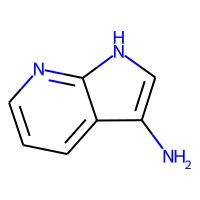
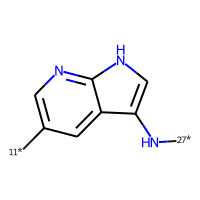
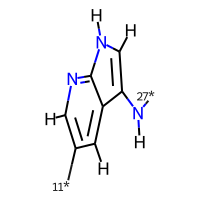
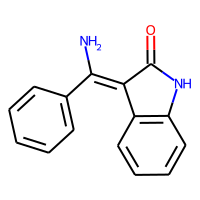
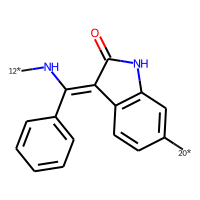
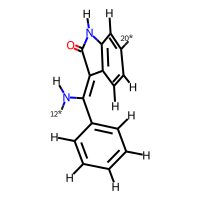
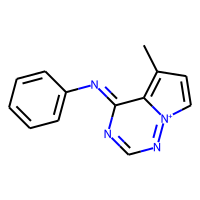
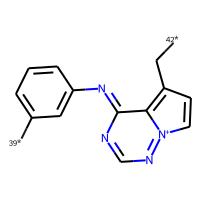
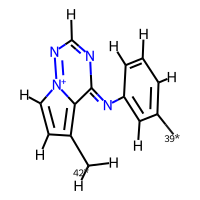
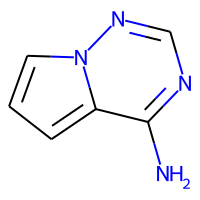
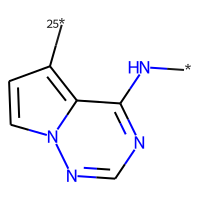
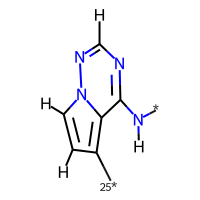
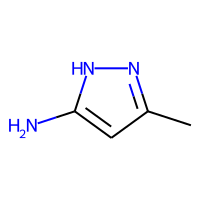
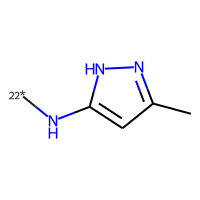
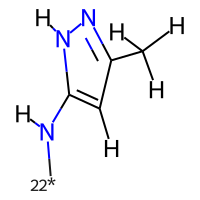

In [63]:
HTML(fragment_library["AP"].head().to_html(notebook=True))

Count number of pre-filtered fragments and number of fragments that are accepted and rejected by the Rule of Three filter.

In [64]:
num_fragments_ro3 = pd.concat(
    [
        filters.analysis.count_fragments(fragment_library, "pre_filtered"),
        filters.analysis.count_accepted_rejected(
            fragment_library, "bool_ro3", "ro3"
        ),
    ],
    axis=1,
)

num_fragments_ro3 = pd.concat(
    [
        num_fragments_ro3,
        num_fragments_ro3.sum().rename("Total").to_frame().T
    ],
    axis=0
)
num_fragments_ro3
# NBVAL_CHECK_OUTPUT

,pre_filtered,accepted_ro3,rejected_ro3
AP,1201,606,595
FP,1100,840,260
SE,743,613,130
GA,355,312,43
B1,47,44,3
B2,59,55,4
Total,3505,2470,1035


## 4. Filter for Quantitative Estimate of Druglikeness (QED)

Quantitative Estimate of Druglikeness (QED) ([Nat Chem. 2012 Jan 24; 4(2): 90–98](https://www.nature.com/articles/nchem.1243)) reflects the distribution of the molecular properties, namely

* molecular weight
* octanol-water-partition-coefficient
* number of hydrogen bond donor and acceptor, 
* polar surface area, 
* number of rotatable bonds, 
* number of aromatic rings 
* and number of structural alerts. 

For each property, a desirability function is used and with them the estimate is calculated.

In [65]:
filters.drug_likeness.get_qed?

Signature:
filters.drug_likeness.get_qed(
    fragment_library,
    cutoff_val=0.492,
    cutoff_crit='>',
)
Docstring:
Calculates the Quantitative Estimate of Druglikeness.

Parameters
----------
fragment_library : dict
    fragments organized in subpockets including all information
cutoff_val : int
    A value defining the cutoff for accepted/rejected fragments. By default, cutoff_val=0.492.
cutoff_crit : str
    Defining whether the QED value should be ">", "<", ">=", "<=", "==" or "!=" compared to
    the cutoff-value. By default ,cutoff_crit=">".

Returns
-------
dict
    Containing a pandas.DataFrame for each subpocket with all fragments and an
    additional columns (bool_qed) defining whether the fragment is accepted (1) or rejected (0)
    and the calculated QED value for each fragment (qed).
File:      ~/Documents/PHD/KinFragLib/KinFragLib/kinfraglib/filters/drug_likeness.py
Type:      function

In [66]:
fragment_library = filters.drug_likeness.get_qed(fragment_library, cutoff_val=0.492)

Inspect individual subpockets, including the new column if QED threshold fulfilled or not per fragment (`bool_qed`) and calculated QED values (`qed`). 

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_ro3,bool_qed,qed
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",1,1,0.565900
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 16 7 16 16 16 16 5 16 16 16 16 16 5 5 5 5 5 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]",1,1,0.747185
2,AP,CC1=C2/C(=N/c3ccccc3)N=CN=[N+]2C=C1,,,,AAK1,NAK,Other,8gmc,YFV,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 16 4 4 4 4...,[39*]c1cccc(/N=C2\N=CN=[N+]3C=CC(C[42*])=C23)c1,1,"[FP, FP]","[AP=FP, AP=FP]",0,1,0.656515
3,AP,Nc1ncnn2cccc12,,,,AAK1,NAK,Other,8gmd,ZRR,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP GA FP,14 14 14 14 14 14 14 16 14 14 14 14 5 5 na na,*Nc1ncnn2ccc([25*])c12,6,"[GA, FP]","[AP=GA, AP=FP]",1,1,0.563803
4,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,10,[SE],[AP=SE],1,0,0.488854

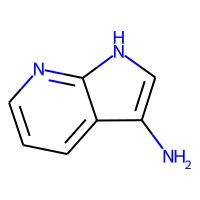
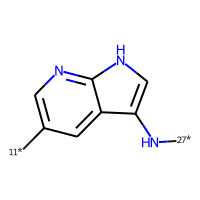
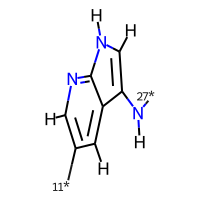
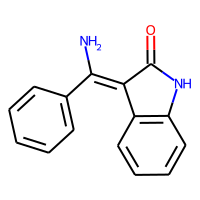
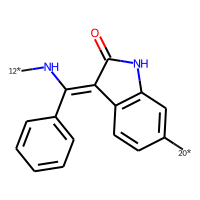
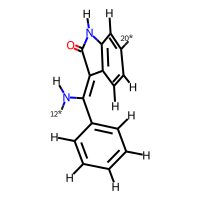
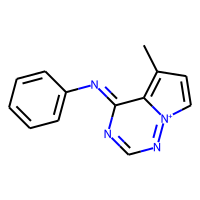
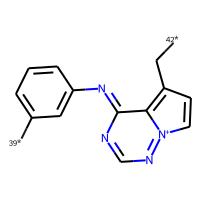
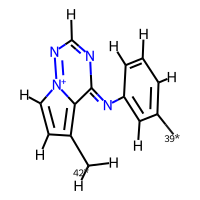
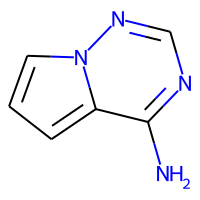
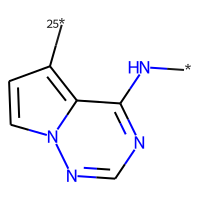
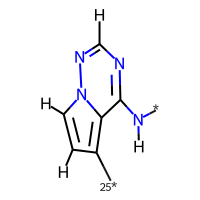
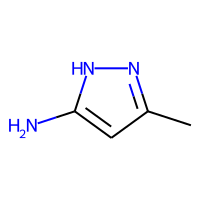
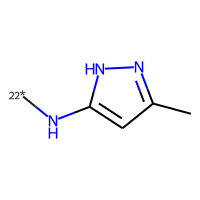
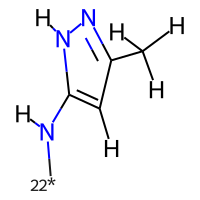

In [67]:
HTML(fragment_library["AP"].head().to_html(notebook=True))

Count number of pre-filtered fragments and number of fragments that are accepted and rejected by the QED filter.

In [68]:
num_fragments_qed = pd.concat(
    [
        filters.analysis.count_fragments(fragment_library, "pre_filtered"),
        filters.analysis.count_accepted_rejected(
            fragment_library, "bool_qed", "qed"
        ),
    ],
    axis=1,
)
num_fragments_qed = pd.concat(
    [num_fragments_qed,
     num_fragments_qed.sum().rename("Total").to_frame().T],
     axis=0
)
num_fragments_qed
# NBVAL_CHECK_OUTPUT

,pre_filtered,accepted_qed,rejected_qed
AP,1201,1064,137
FP,1100,759,341
SE,743,550,193
GA,355,234,121
B1,47,25,22
B2,59,33,26
Total,3505,2665,840


## 5. Analyze accepted/rejected fragments

    5.1. Count number of fragments that are accepted by the filter(s)

    5.2. Histogram of QED values

### 5.1. Count number of fragments that are accepted by the filter(s)

In [69]:
fragment_library = filters.analysis.number_of_accepted(
    fragment_library, columns=["bool_ro3", "bool_qed"], min_accepted=2
)

In [70]:
filters.analysis.accepted_num_filters(
    fragment_library,
    ["bool_qed", "bool_ro3"],
    filtername="drug likeness filters",
    max_num_accepted=2,
)

,pre-filtered,accepted by 2,accepted by 1,accepted by 0
AP,1201,541,588,72
FP,1100,546,507,47
SE,743,439,285,19
GA,355,206,134,15
B1,47,23,23,1
B2,59,29,30,0
Total,3505,1784,1567,154


### 5.2. Histogram of QED values
Create a histogram for each subpocket showing the QED values and the chosen threshold.

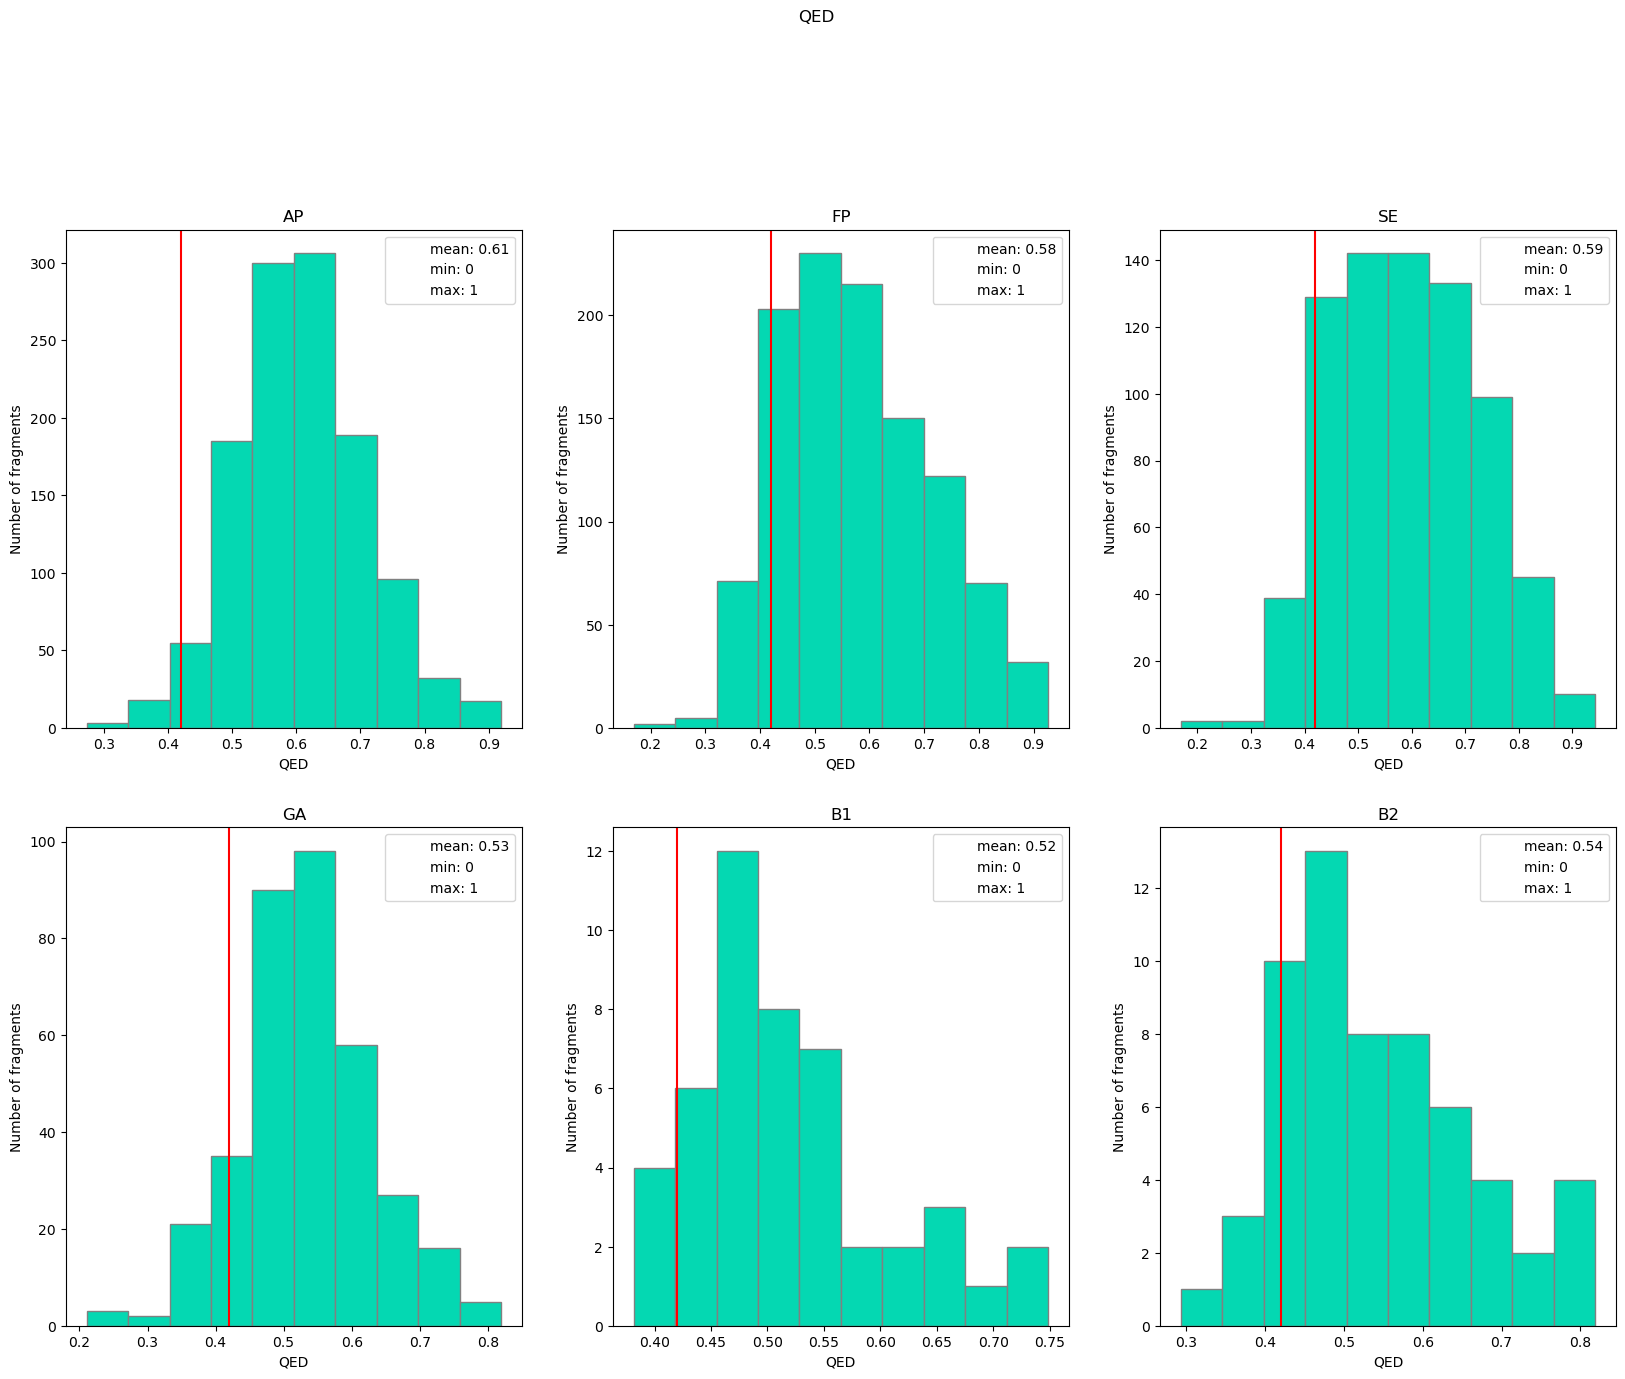

In [71]:
filters.plots.make_hists(
    fragment_library, "qed", "QED", plot_stats=True, cutoff=0.42
)

### 5.3. Examples of rejected molecules (QED)

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_ro3,bool_qed,qed,bool
632,AP,O=C1Nc2ccc([SH](=O)=O)cc2/C1=C1/Nc2ccccc2/C1=N\O,,,,GSK3B,GSK,CMGC,3say,OFT,A,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 12 12 12 12 12 1...,[34*]S(=O)(=O)c1ccc2c(c1)/C(=C1/Nc3ccccc3/C1=N...,1,[FP],[AP=FP],0,0,0.272835,0
1068,AP,O=C[O-],,,,TBK1,IKK,Other,5w5v,ANW,,A,AP AP AP SE,6 6 6 na,[25*]C(=O)[O-],1,[SE],[AP=SE],1,0,0.306547,0
233,AP,NNC(=O)c1n[nH]c2c1CCCC2,,,,CDK2,CDK,CMGC,3r8l,Z30,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,14 14 14 14 14 14 14 14 14 14 15 14 14 14 14 1...,[12*][C@@H]1CCc2[nH]nc(C(=O)NN)c2C1,2,[FP],[AP=FP],0,0,0.320152,0
468,AP,N/C=C\C=O,,,,CaMKK2,CAMKK,Other,5yv9,91O,,A,AP AP AP AP AP AP AP AP GA SE,5 5 6 5 5 5 5 5 na na,[16*]C(=O)/C=C\N[28*],1,"[GA, SE]","[AP=GA, AP=SE]",1,0,0.339152,0
129,AP,NC=O,,,,BTK,Tec,TK,4z3v,4L6,B,A,AP AP AP AP AP FP,1 5 5 5 1 na,[29*]C(N)=O,28,[FP],[AP=FP],1,0,0.352326,0

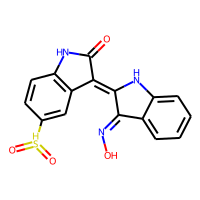
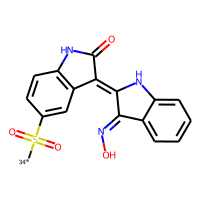
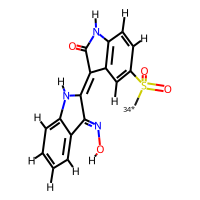
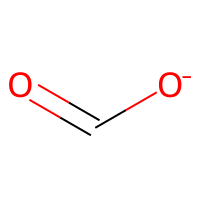
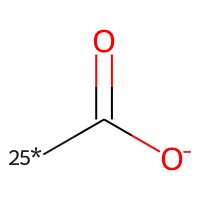
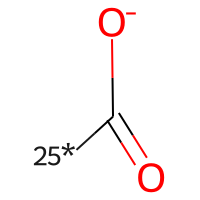
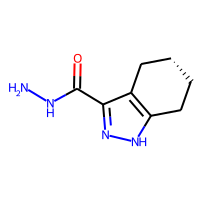
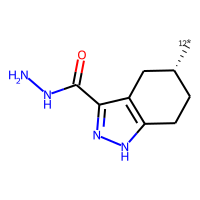
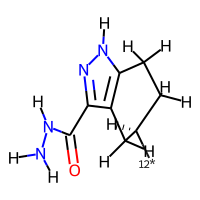
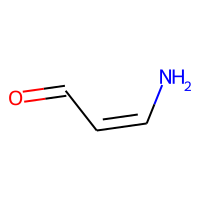
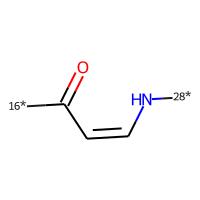
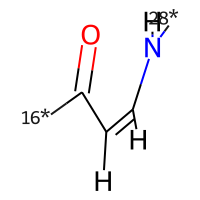
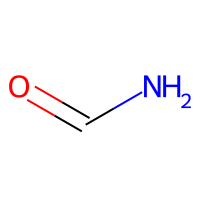
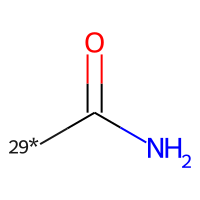
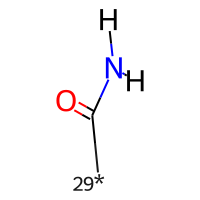

In [72]:
# data frame with all molecules rejected by QED
rejected_fragments = fragment_library["AP"][fragment_library["AP"]["bool_qed"] == 0].sort_values(by=["qed"])
HTML(rejected_fragments.head().to_html(notebook=True))

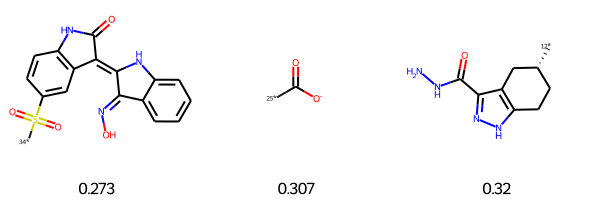

In [73]:
molecules = [rejected_fragments.iloc[i].ROMol_dummy for i in range(3)]
qed_score = [rejected_fragments.iloc[i].qed for i in range(3)]

mol_image = Draw.MolsToGridImage(molecules, molsPerRow=3, legends=[str(round(x, 3)) for x in qed_score], useSVG=True)
with open('figures/qed_molecules.svg', 'w') as f:
    f.write(mol_image.data)
mol_image

### 5.4. Examples of rejected molecules (Ro3)

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_ro3,bool_qed,qed,bool
2,AP,CC1=C2/C(=N/c3ccccc3)N=CN=[N+]2C=C1,,,,AAK1,NAK,Other,8gmc,YFV,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 16 4 4 4 4...,[39*]c1cccc(/N=C2\N=CN=[N+]3C=CC(C[42*])=C23)c1,1,"[FP, FP]","[AP=FP, AP=FP]",0,1,0.656515,0
6,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,4 4 4 14 4 5 5 1 1 4 4 4 4 4 4 4 4 4 4 3 3 3 3...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]",0,1,0.723961,0
8,AP,COc1cc2ncnc(N)c2cc1OC,,,,ABL1,Abl,TK,8ssn,SKI,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,3 3 3 3 16 16 16 16 16 16 16 16 14 16 16 3 3 3...,[15*]Nc1ncnc2cc(OC)c(OC)cc12,7,[GA],[AP=GA],0,1,0.797952,0
10,AP,Nc1nccc(O)n1,,,,ACK,Ack,TK,3eqp,T95,,B,AP AP AP AP AP AP AP AP AP AP FP SE GA,16 14 14 14 14 3 14 14 5 5 na na na,[1*]c1cnc(N[49*])nc1O[27*],2,"[FP, SE, GA]","[AP=FP, AP=SE, AP=GA]",0,0,0.484475,0
11,AP,Nc1ncc2cn[nH]c2n1,,,,ACK,Ack,TK,3eqr,T74,,A,AP AP AP AP AP AP AP AP AP AP AP AP GA SE FP,9 14 14 14 14 14 14 14 14 14 5 5 na na na,[17*]n1nc([24*])c2cnc(N[51*])nc21,2,"[GA, SE, FP]","[AP=GA, AP=SE, AP=FP]",0,1,0.529676,0

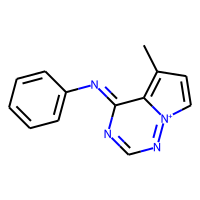
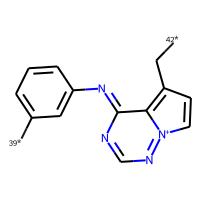
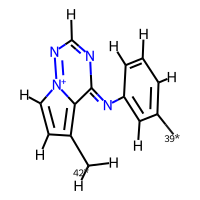
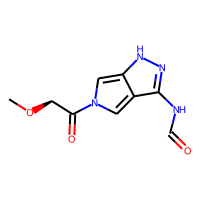
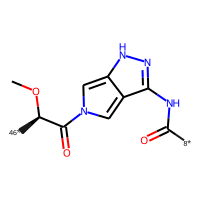
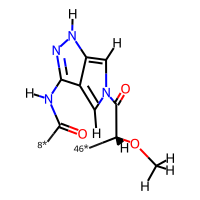
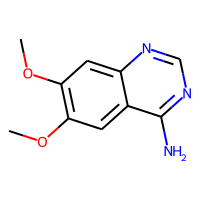
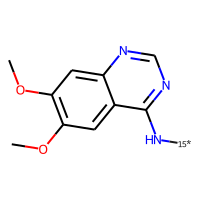
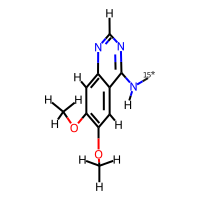
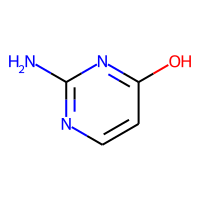
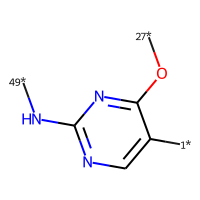
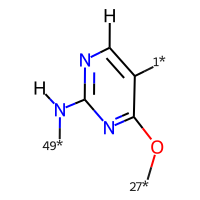
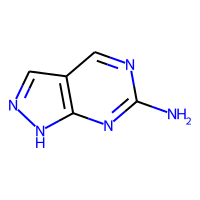
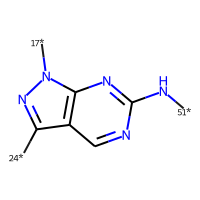
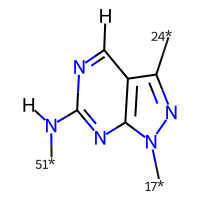

In [74]:
# data frame with all molecules rejected by QED
rejected_fragments = fragment_library["AP"][fragment_library["AP"]["bool_ro3"] == 0]
HTML(rejected_fragments.head().to_html(notebook=True))

In [75]:
# add Ro3 properties to dataframe 
rejected_fragments["MW"] = [QED.properties(mol).MW for mol in rejected_fragments.ROMol]
rejected_fragments["LogP"] = [QED.properties(mol).ALOGP for mol in rejected_fragments.ROMol]
rejected_fragments["HBD"] = [QED.properties(mol).HBD for mol in rejected_fragments.ROMol]
rejected_fragments["HBA"] = [QED.properties(mol).HBA for mol in rejected_fragments.ROMol]
rejected_fragments["ROTB"] = [QED.properties(mol).ROTB for mol in rejected_fragments.ROMol]
rejected_fragments["PSA"] = [QED.properties(mol).PSA for mol in rejected_fragments.ROMol]

/var/folders/9p/vmw7ktwj05v2jfcjtj798dcw0000gn/T/ipykernel_13251/743631842.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rejected_fragments["MW"] = [QED.properties(mol).MW for mol in rejected_fragments.ROMol]
/var/folders/9p/vmw7ktwj05v2jfcjtj798dcw0000gn/T/ipykernel_13251/743631842.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rejected_fragments["LogP"] = [QED.properties(mol).ALOGP for mol in rejected_fragments.ROMol]
/var/folders/9p/vmw7ktwj05v2jfcjtj798dcw0000gn/T/ipykernel_13251/743631842.py

Extract one molecule example for each property, which has been rejected. 

In [76]:
# extract index of molecule 
rejected_examples = []
# extract legend text with property name and value 
legend = []

rejected_examples.append(rejected_fragments["MW"].idxmax())
legend.append("MW=" + str(rejected_fragments.loc[rejected_examples[-1]].MW))
rejected_examples.append(rejected_fragments["LogP"].idxmax())
legend.append("LogP=" + str(round(rejected_fragments.loc[rejected_examples[-1]].LogP,2)))
rejected_examples.append(rejected_fragments["HBD"].idxmax())
legend.append("HBD=" + str(rejected_fragments.loc[rejected_examples[-1]].HBD))
rejected_examples.append(rejected_fragments["HBA"].idxmax())
legend.append("HBA=" + str(rejected_fragments.loc[rejected_examples[-1]].HBA))
rejected_examples.append(rejected_fragments["ROTB"].idxmax())
legend.append("ROTB=" + str(rejected_fragments.loc[rejected_examples[-1]].ROTB))
rejected_examples.append(rejected_fragments["PSA"].idxmax())
legend.append("PSA=" + str(rejected_fragments.loc[rejected_examples[-1]].PSA))


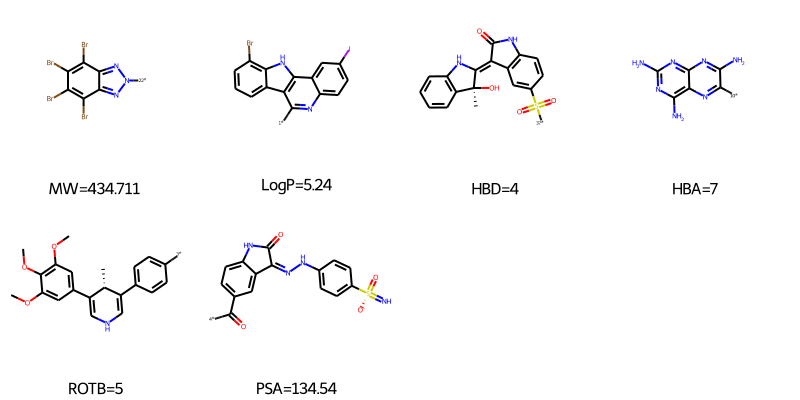

In [77]:
molecules = [rejected_fragments.loc[i].ROMol_dummy for i in rejected_examples] 

mol_image = Draw.MolsToGridImage(molecules, molsPerRow=4, legends=legend, useSVG=True)
with open('figures/Ro3_molecules.svg', 'w') as f:
    f.write(mol_image.data)
display(mol_image)